In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics as st
from datetime import datetime

In [12]:
model_path = "/home/aevans/convLSTM/src/data/temp_df/20240330/Mohawk Valley/20240330_23:53_ml_output.parquet"

clim_div = 'Mohawk Valley'

# full_df_path = '/home/aevans/transformer_ml/src/data/temp_df/20240329/Mohawk Valley/Mohawk Valley_CAMD.parquet'

In [13]:
nysm_cats_path = "/home/aevans/nwp_bias/src/landtype/data/nysm.csv"
nysm_cats_df = pd.read_csv(nysm_cats_path)
stations = nysm_cats_df[nysm_cats_df['climate_division_name']==clim_div]['stid'].unique()
stations

array(['CAMD', 'HERK', 'JOHN', 'OPPE', 'SPRA', 'WEST'], dtype=object)

In [14]:
df = pd.read_parquet(model_path)
df = df.sort_index()

In [15]:
df

,0_convLSTM_output,0_target,1_convLSTM_output,1_target,2_convLSTM_output,2_target,3_convLSTM_output,3_target,4_convLSTM_output,4_target,5_convLSTM_output,5_target
0,-0.001209,-0.314755,0.005788,0.027452,0.007188,-0.534891,0.006962,0.609343,0.005385,-1.384741,-0.002118,-1.533985
1,-0.000737,-0.647333,0.007530,0.316203,0.010009,-1.099413,0.009990,0.595250,0.007572,-1.958878,-0.001317,-1.747250
2,-0.001286,-0.167850,0.005492,0.263237,0.006706,-0.091111,0.006487,-0.140074,0.005014,-1.297019,-0.002246,-1.788382
3,-0.000640,-0.483740,0.007832,0.380887,0.010347,-0.044857,0.010192,1.576964,0.007662,-0.926346,-0.001296,-0.159364
4,-0.000833,2.301675,0.007134,0.451185,0.009294,0.074448,0.009140,0.892727,0.006890,0.769951,-0.001587,-0.180089
...,...,...,...,...,...,...,...,...,...,...,...,...
48542,-0.001290,-0.610262,0.005687,-0.351226,0.007080,-0.769265,0.007458,0.083325,0.006117,-0.563675,-0.001334,-0.049682
48543,-0.001294,-1.094895,0.005672,-1.164314,0.007059,-0.745370,0.007442,-0.200732,0.006108,-0.698523,-0.001337,-0.564140
48544,-0.001298,-1.268585,0.005659,-1.550458,0.007041,-0.987515,0.007429,-0.678765,0.006102,-1.117133,-0.001338,-0.757786
48545,-0.001301,-1.173881,0.005649,-1.503778,0.007028,-0.725308,0.007419,-0.630712,0.006098,-1.429067,-0.001339,-0.780501


In [16]:
# full_df = pd.read_parquet(full_df_path)

In [17]:
def which_fold(df, fold):
    length = len(df)
    test_len = int(length * 0.2)
    df_train = pd.DataFrame()

    for n in np.arange(0, 5):
        if n != fold:
            df1 = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            df_train = pd.concat([df_train, df1])
        else:
            df_test = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]

    return df_train['valid_time'], df_test['valid_time']

In [18]:
# df_train, df_test = which_fold(full_df, 3)

In [19]:
# df_test.iloc[0]

In [20]:
# df_test.iloc[-1]

In [21]:
# vt = full_df['valid_time'].to_list()
# vt = vt[:int(len(df)-len(full_df))]
# df['valid_time'] = vt

In [22]:
# df = df[df['valid_time'] > datetime(2021, 9, 1, 0, 0, 0)]
# df = df[df['valid_time'] < datetime(2022, 10, 30, 23, 0, 0)]
# df = df.drop(columns='valid_time')

In [29]:
def plot_outputs(df_out, clim_div, stations):
    import matplotlib.pyplot as plt 
    df_out = df_out.sort_index()
    fig, axs = plt.subplots(int(df_out.shape[1]/2), figsize=(21, 21), sharex=True, sharey=True)
    n = int(df_out.shape[1]/2)
    i = 0
    while n>i:
        axs[i].set_ylabel(f'{stations[i]}')
        axs[i].plot(df_out[f'{i}_target'], c="r", label="Target")
        axs[i].plot(df_out[f"{i}_convLSTM_output"], c="b", alpha=0.7, label="convLSTM Output")
        
        print(f"Mean Absolute Difference of {stations[i]}: {abs(df_out[f'{i}_target'] - df_out[f'{i}_convLSTM_output']).mean()}")
        i+=1
    fig.suptitle(f"convLSTM Output v Target", fontsize=28)
    axs[-1].set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023], fontsize=18)
    axs[-1].set_xticks(np.arange(0, len(df_out["0_target"])+1, (len(df_out["0_target"])) / 6))
    axs[0].legend()
    plt.tight_layout()

Mean Absolute Difference of CAMD: 0.7605196508037866
Mean Absolute Difference of HERK: 0.7706159235421937
Mean Absolute Difference of JOHN: 0.7550173166228928
Mean Absolute Difference of OPPE: 0.7443730287939512
Mean Absolute Difference of SPRA: 0.7573414678906758
Mean Absolute Difference of WEST: 0.7173189347553026


/tmp/tmp.ueb2SZtQZT/ipykernel_2481136/562706163.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[-1].set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023], fontsize=18)


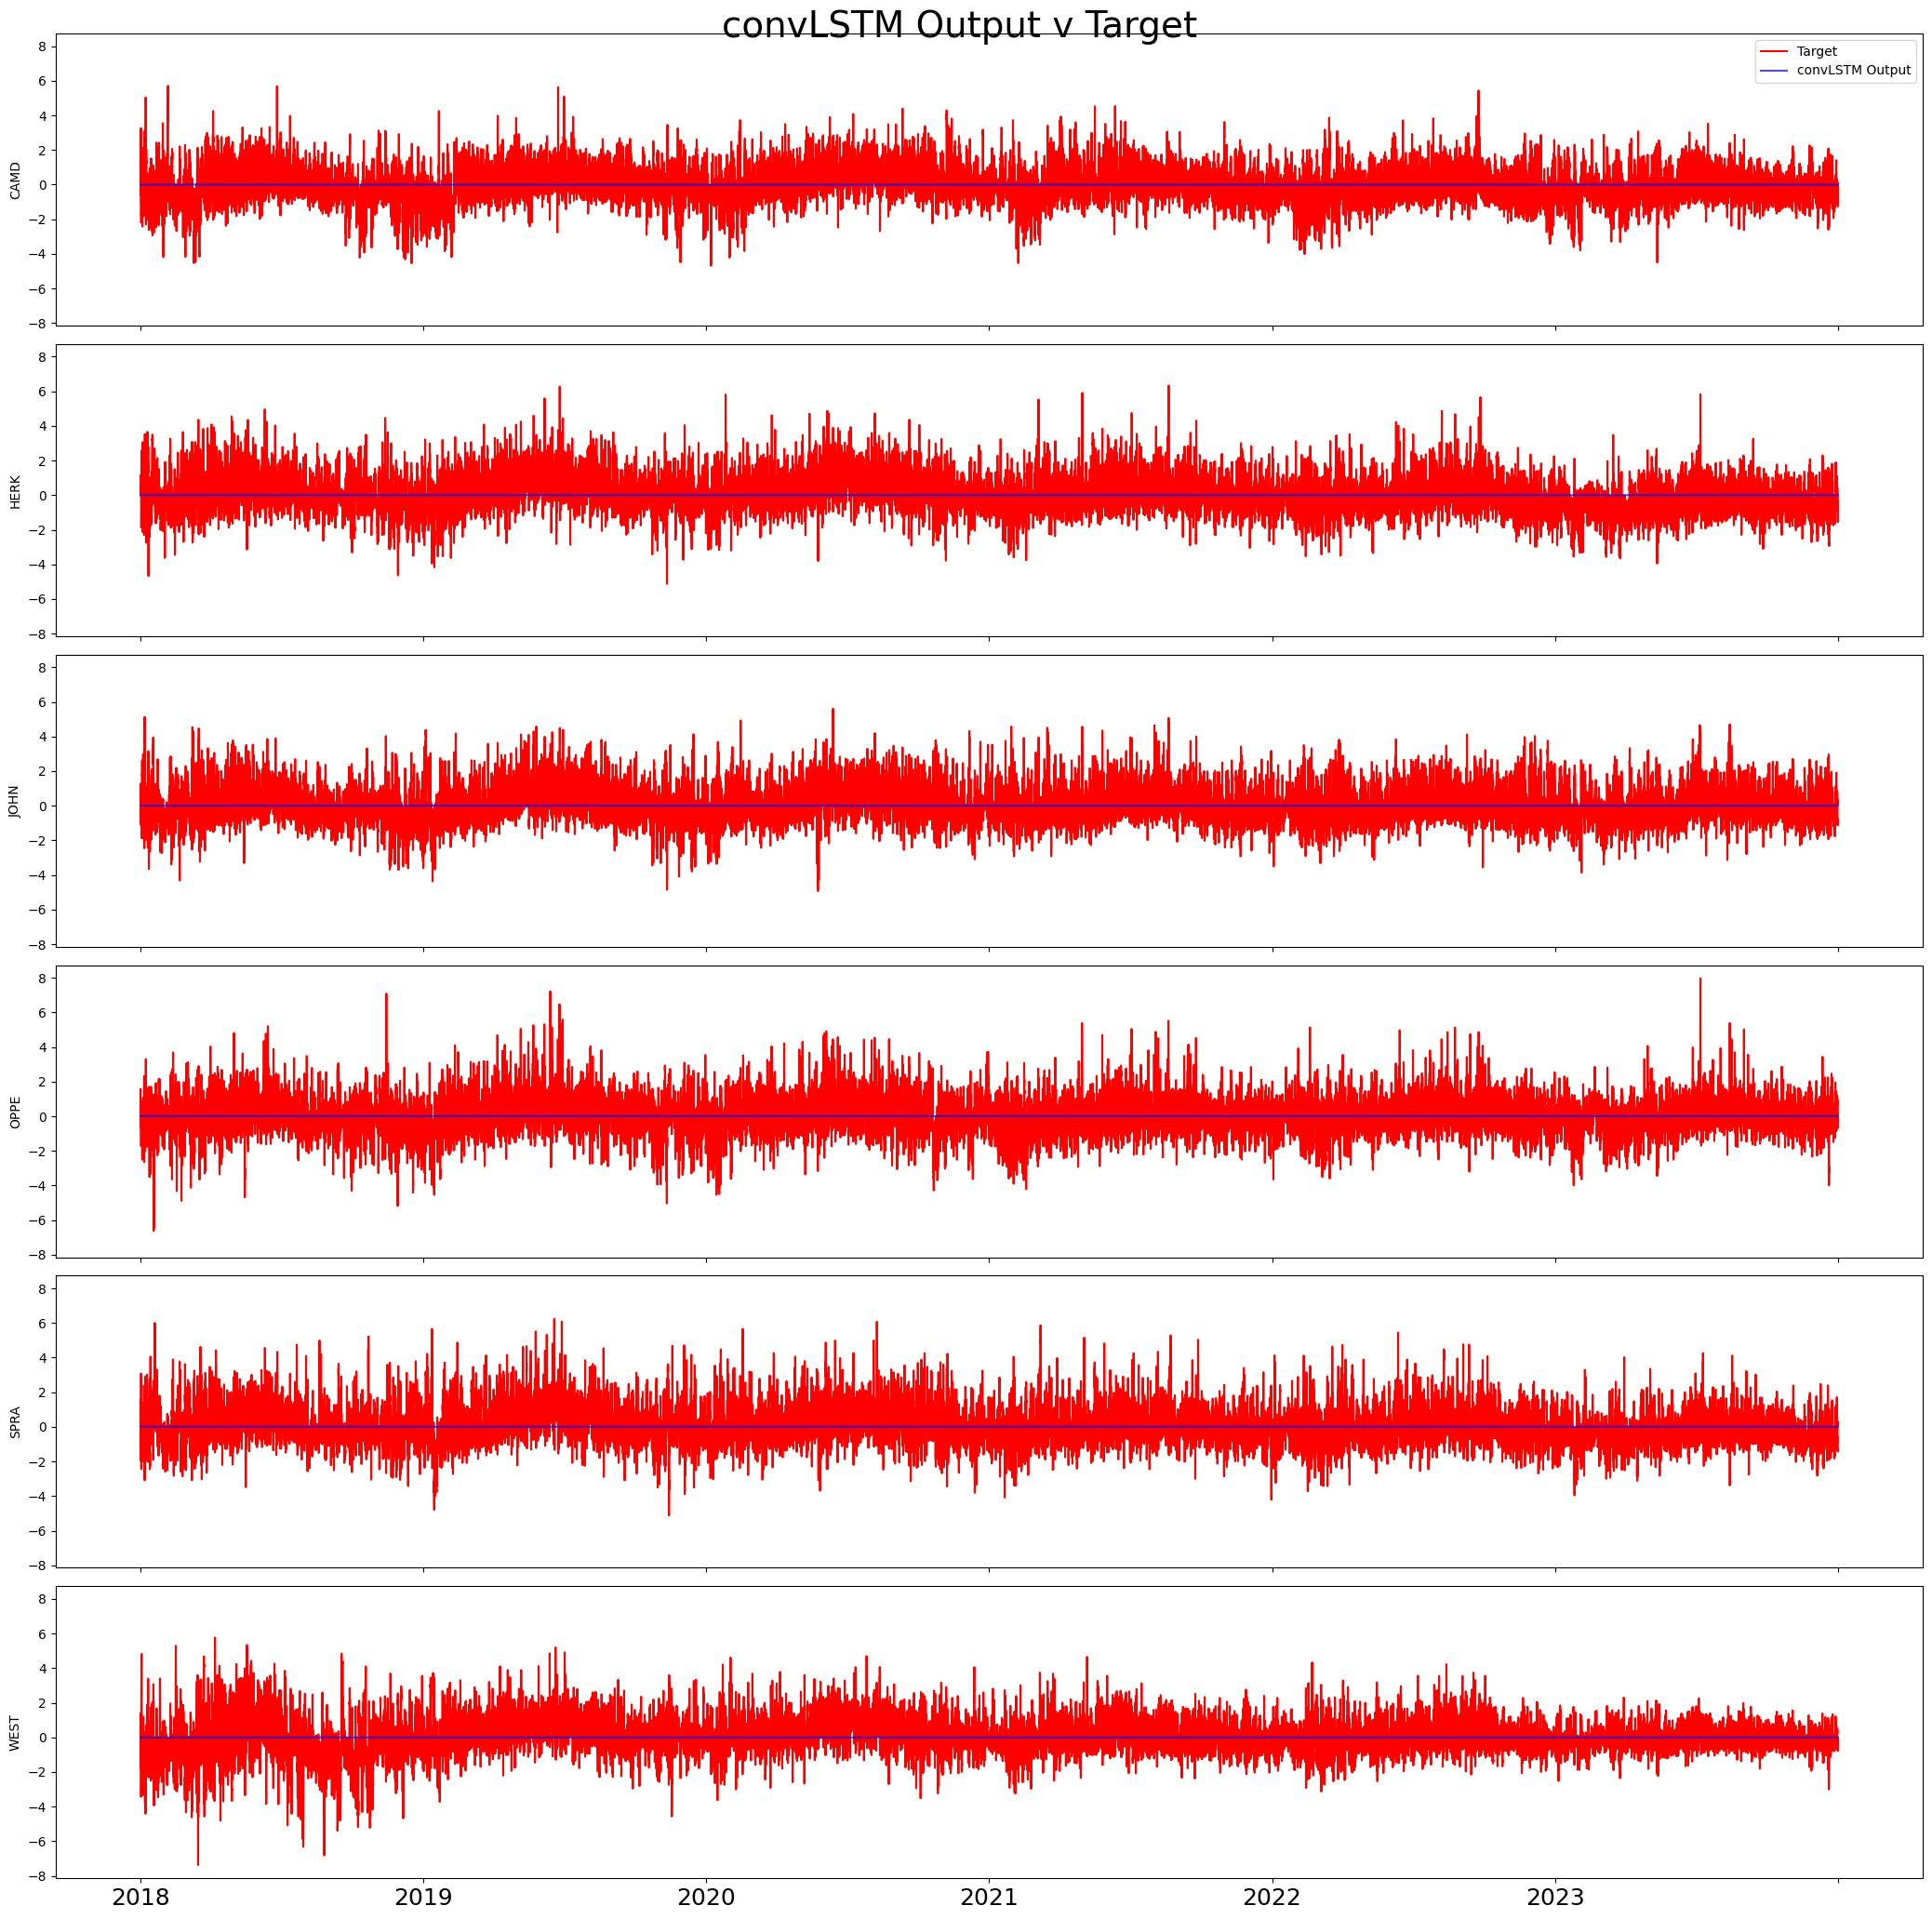

In [30]:
plot_outputs(df, clim_div, stations)